## Fit a DelayedSaturatedMMM with TVP
There are many ways to use time-varying parameters in an MMM. Here are some things one might want to do with TVP in MMM:
1) Time-varying intercept
2) Single time-varying parameter that models a time-varying factor which modulates total effect of media spend. Like `mu = media_contribution.sum(-1) * time_varying_factor + ...`
3) Each (or selected) channel `beta`s are seperate time-varying coefficients. This is the most flexible and general approach, and probably the most desired out there, but it's also somewhat unweildy and can very easily overfit to noise. The best approach when doing this is to have a hierarchical hyperprior 
4) 
... and 1 and 2 are not mutually exclusive.

In this notebook I demonstrate the use of 2.

In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import pymc as pm

from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM

In [2]:
pd.set_option('display.max_columns', None)

## Create some data for testing

#### → Load input (channel spend/impressions and control data)

In [3]:
# Load some synthetic impression+control data
data = pd.read_csv("mock_cgp_data-no-target.csv", parse_dates=["Weeks"])

# Define which columns are media and control
coords = {
    "media": ["Google Search", "DV360", "Facebook", "AMS", "TV", "VOD", "OOH", "Radio"],
    "control": ["Numeric Distribution", "RSP", "Promotion"],
    "week": data["Weeks"],
}

#### → Simulate a target (e.g. sales)

<Axes: title={'center': 'Target'}>

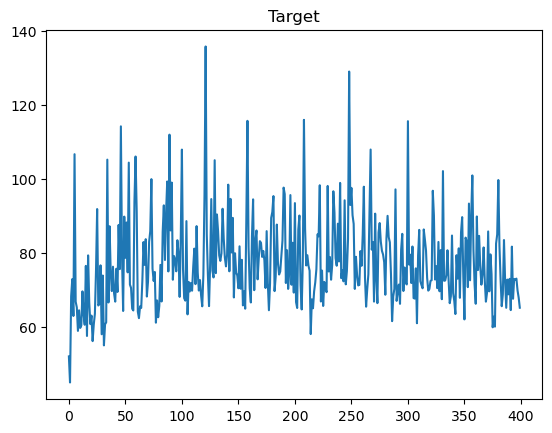

In [4]:
# Create the model, with channel spend, control variables, adstock, and yearly seasonality
mmm = DelayedSaturatedMMM(
    date_column="Weeks",
    channel_columns=coords["media"],
    control_columns=coords["control"],
    adstock_max_lag=10,
    sampler_config={"nuts_sampler": "numpyro"},
)

true_params = {
    "intercept": 5,
    "beta_channel": (data[coords["media"]].max(0)).values * np.array([3.5, 2.0, 5.0, 3.2, 1.5, 2.0, 1.0, 1.5]) * 7,
    "alpha": np.array([0, 0.5, 0.1, 0.1, 0.9, 0.5, 0.9, 0.95]),
    "lam": 1 / (data[coords["media"]].mean(0)).values,
    "likelihood_sigma": 0.25,
    "gamma_control": np.array([-0.5, 1, 0.25]),
}

mmm.build_model(data, np.ones(data.shape[0]))

true_model = pm.do(
    mmm.model,
    true_params,
)

plt.title("Target")
data["target"] = pm.draw(true_model.y)
data["target"].plot()

#### → Modulate sales by a yearly seasonality
... so we have a time-varying effect to model.

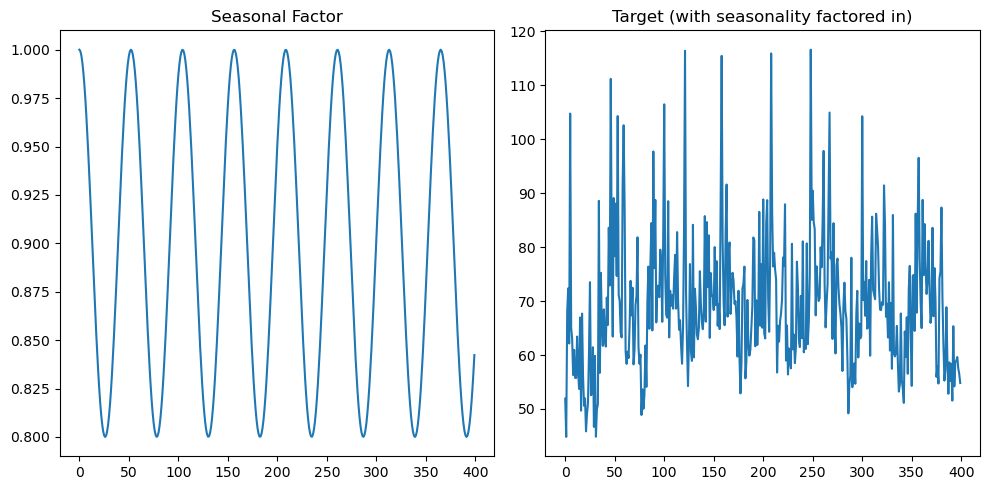

In [5]:
seasonal_factor = (np.cos(np.arange(data.shape[0]) / 52.1429 * 2 * np.pi) + 9) / 10
data["target"] *= seasonal_factor

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# First plot
axs[0].plot(seasonal_factor)
axs[0].set_title('Seasonal Factor')

# Second plot
axs[1].plot(data["target"])
axs[1].set_title('Target (with seasonality factored in)')

plt.tight_layout()
plt.show()

#### → Split into train and test

In [6]:
# Split into train and test
data_train = data.iloc[:-52]
data_test = data.iloc[-52:]

## Fit a DelayedSaturatedMMM with TVP
We write a new `TVPMMM` class to do this. It's a copy of `DelayedSaturatedMMM` with the `build` method overwritten. The updates are:

* Add `time_index` `MutableData` object to the model. This is required by the `time_varying_prior` function, and allows us to predict out of sample with a model that incorporates a TVP.
* Add `time_varying_factor_media` and `time_varying_factor_intercept` priors. These are the TVPs.
* Update the contribution terms to factor in these TVPs. 

#### → Fit the model

In [8]:
mmm = DelayedSaturatedMMM(
    date_column="Weeks",
    channel_columns=coords["media"],
    control_columns=coords["control"],
    adstock_max_lag=10,
    time_varying_intercept=True,
    sampler_config={"chains": 2, "draws": 400, "nuts_sampler": "numpyro"},
)
# mmm.build_model(data_train, data_train["target"].values)
mmm.fit(data_train, data_train["target"])

Only 400 samples in chain.
Compiling...
Compilation time = 0:00:02.408851
Sampling...


  0%|          | 0/1400 [00:00<?, ?it/s]

  0%|          | 0/1400 [00:00<?, ?it/s]

#### → Diagnose it

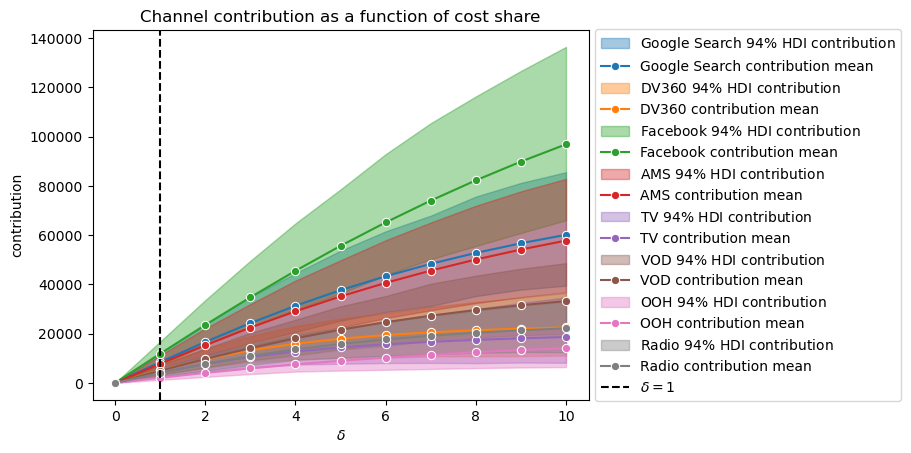

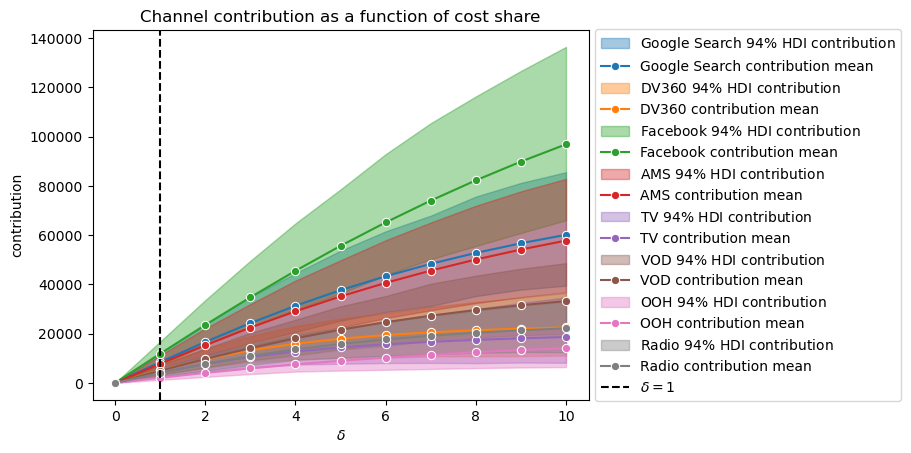

In [8]:
mmm.plot_channel_contributions_grid(0, 10, 11)

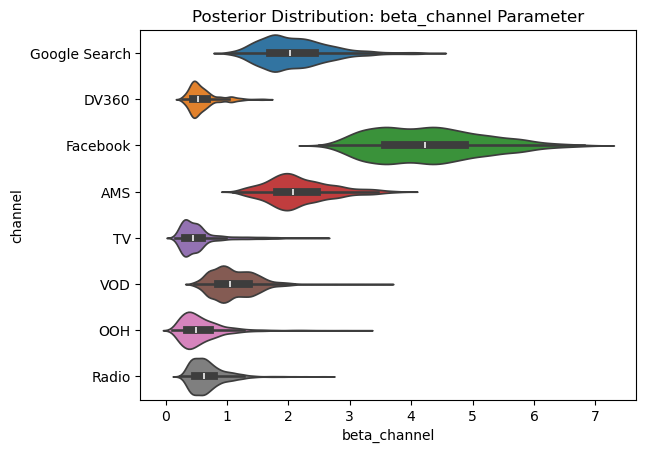

In [9]:
_ = mmm.plot_channel_parameter('beta_channel')

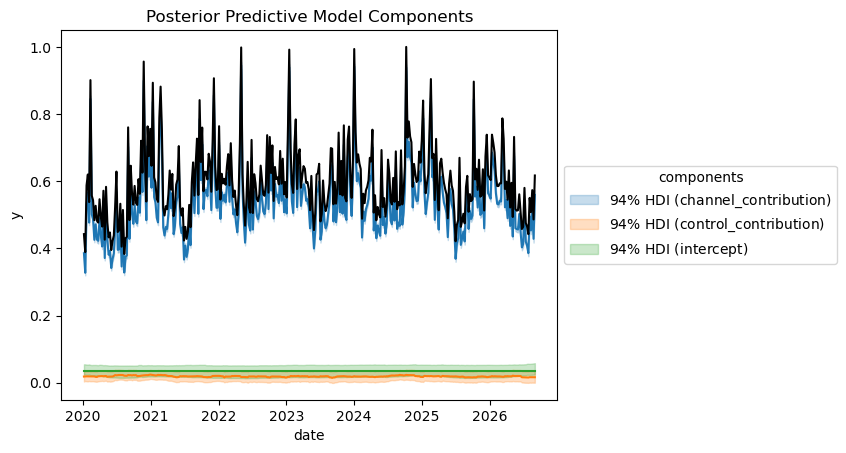

In [10]:
_ = mmm.plot_components_contributions()

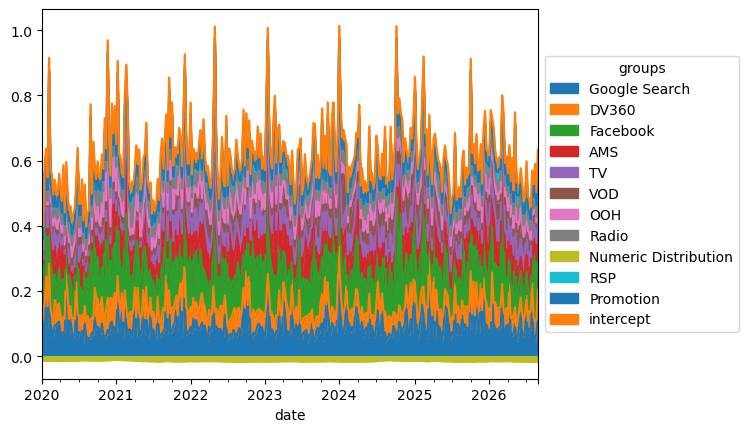

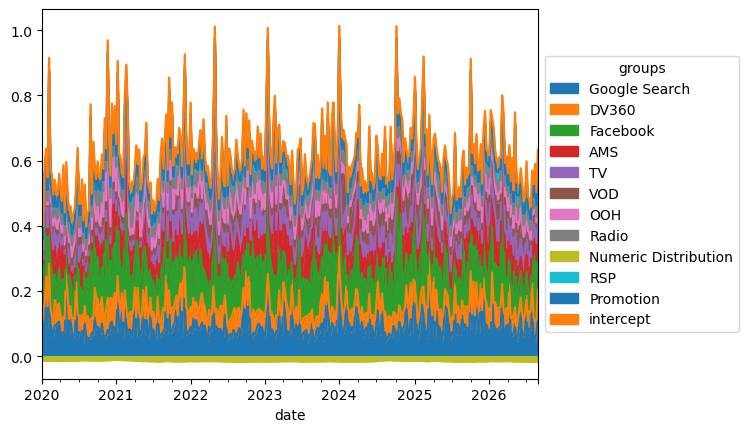

In [11]:
mmm.plot_grouped_contribution_breakdown_over_time()

#### → Plot out of sample predictive

Sampling: [y]


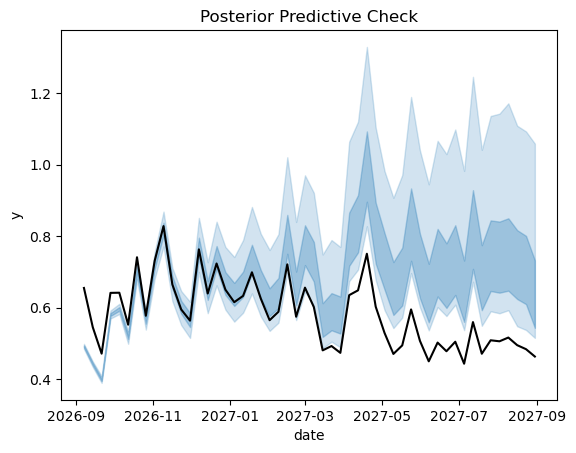

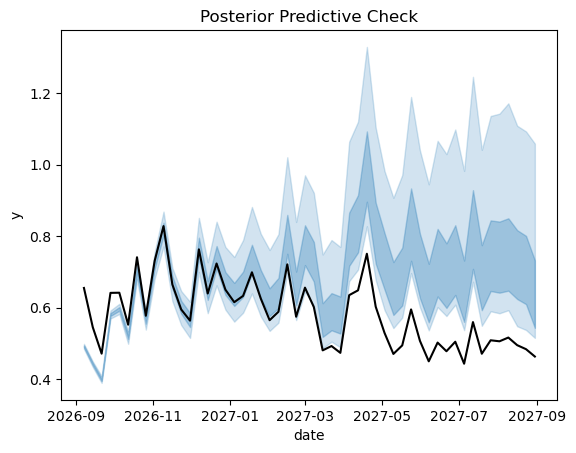

In [13]:
mmm.sample_posterior_predictive(X_pred=data_test)
mmm.y = data_test["target"].values
mmm.plot_posterior_predictive()